In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from collections import defaultdict
from numpy.linalg import inv

In [2]:
label_map = {}
for i in range(0, 133):
    label_map[f'{i}'] = i

In [3]:
# Open the h5 file

import h5py

# Function to recursively load data from an HDF5 file into a Python dictionary
def load_dict_from_h5(file_name):
    data = {}
    
    # Open the HDF5 file
    with h5py.File(file_name, 'r') as f:
        # Recursively extract the groups and datasets into a dictionary
        def read_group(group, data_dict):
            for key, value in group.items():
                if isinstance(value, h5py.Group):
                    # If it's a group (nested dictionary), recursively read it
                    data_dict[key] = {}
                    read_group(value, data_dict[key])
                else:
                    # If it's a dataset, store it in the dictionary
                    data_dict[key] = value[()]
        
        # Start reading the file from the root group
        read_group(f, data)
    
    return data

# Load the HDF5 file into a variable
label_matrix = load_dict_from_h5('output.h5')


In [4]:
label_map = {}
for key in label_matrix:
    label_map[key] = {}
    for i in range(0, 133):
        label_map[key][f'{i}'] = i

In [5]:
label_matrix.keys()

dict_keys(['1003to1469', '1005to1143', '1005to1293', '1006to1376', '1033to1119', '1053to1571', '106to721', '1082to1542', '1095to1491', '1105to1126', '1150to1522', '1168to1262', '1169to1317', '1179to1287', '1179to1562', '1184to1409', '118to746', '1230to1538', '1230to1599', '1242to1248', '1255to1525', '1260to1274', '1274to1462', '1280to1492', '1294to1577', '1380to1396', '1383to1407', '13to266', '1462to1500', '1515to1577', '1550to1573', '157to1119', '159to739', '174to643', '188to1002', '1to783', '24to771', '276to330', '281to477', '298to590', '306to1517', '314to596', '320to735', '322to1438', '323to1022', '329to787', '341to701', '356to634', '357to780', '365to1488', '376to625', '397to1127', '468to1595', '470to1359', '515to598', '525to767', '531to1235', '539to714', '547to585', '547to706', '562to581', '567to1244', '56to1291', '572to697', '5to687', '607to1139', '629to794', '63to445', '642to1444', '658to790', '670to708', '72to784', '741to743', '757to796', '800to1128', '810to1212', '813to996', '8

In [6]:
def create_final_matrix(label_dict, centroids = 132):
    max_t = 0
    max_fixed_t = 0
    for key in label_dict:
        start = int(key.split('to')[0])
        end = int(key.split('to')[1])
        max_t = max(end, max_t)
        max_fixed_t = max(start, max_fixed_t)
    dim = (max_t+1)*centroids # Assume we start at 0
    print(dim)
    final_matrix = np.zeros((dim, dim))
    label_map = {}
    for key,value in label_dict.items():
        start = int(key.split('to')[0])
        end = int(key.split('to')[1])
        if start not in label_map:
            label_map[start] = {}
        if end not in label_map:
            label_map[end] = {}
        start_val = start*centroids
        end_val = end*centroids
        final_matrix[start_val:start_val+centroids, end_val:end_val+centroids] = value
    for timestamp in label_map:
        for i in range(0, 133):
            label_map[timestamp][i] = i        
    return final_matrix, label_map

In [ ]:
final_matrix, label_map = create_final_matrix(label_matrix)

In [ ]:
final_matrix.shape

In [ ]:
import matplotlib.pyplot as plt
#plt.matshow(final_matrix[1000:5000,1000:10000])
np.sum(final_matrix>0)


## SparseClustering.jl
Recreation of sparse clustering in Python

In [ ]:
#https://github.com/flavell-lab/SparseClustering.jl/blob/main/src/unionfind.jl

class UnionFind:
    def __init__(self, n):
        """
        Initializes a UnionFind data structure for n elements.

        Args:
        - n (int): The number of elements.
        """
        self.parent = list(range(n))  # Parent array: Each element points to itself initially.
        self.rank = [0] * n  # Rank array: Initialize ranks to 0.

    def find(self, x):
        """
        Finds the representative (root) of the subset containing x with path compression.

        Args:
        - x (int): The element whose representative we want to find.

        Returns:
        - int: The representative (root) of the subset containing x.
        """
        if self.parent[x] != x:
            # Path compression: flatten the structure by pointing directly to the root.
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        """
        Merges the subsets containing x and y using union by rank.

        Args:
        - x (int): The first element to merge.
        - y (int): The second element to merge.
        """
        rootX = self.find(x)
        rootY = self.find(y)

        if rootX != rootY:
            # Union by rank: Attach the smaller tree to the root of the larger tree
            if self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
            elif self.rank[rootX] < self.rank[rootY]:
                self.parent[rootX] = rootY
            else:
                # If both have the same rank, attach rootY to rootX and increase rank of rootX
                self.parent[rootY] = rootX
                self.rank[rootX] += 1


In [ ]:
# https://github.com/flavell-lab/SparseClustering.jl/blob/main/src/util.jl

def sort_distance_matrix(s):
    """
    Sort the non-zero entries of the upper triangular part of a sparse distance matrix
    and return the (i, j) indices of these entries sorted by their values.
    
    Arguments:
    - s (scipy.sparse.csr_matrix): A sparse matrix, typically representing a distance matrix.
    
    Returns:
    - List of tuples: A list of (i, j) index tuples sorted by the distance values.
    """
    coo = s.tocoo()
    pairs = []
    for i, j, value in zip(coo.row, coo.col, coo.data):
        if i < j:  # Only consider the upper triangular part (excluding the diagonal)
            pairs.append((i, j, value))
    
    pairs.sort(key=lambda x: x[2])
    return [(i, j) for i, j, _ in pairs]


def generate_timepoint_map(inv_map, n, max_timept):
    """
    Generate a matrix representing time points where each ROI was detected.
    
    Arguments:
    - inv_map (dict): A dictionary where each key is an ROI, and each value is a set of time points where the ROI was found.
    - n (int): Number of ROIs.
    - max_timept (int): The maximum number of time points in the dataset.
    
    Returns:
    - numpy.ndarray: A matrix of size n x max_timept. The entry (i, j) is 1 if the i-th ROI was detected at time point j, 0 otherwise.
    """
    timepoint_map = np.zeros((n, max_timept), dtype=int)
    
    for roi, timepoints in inv_map.items():
        for t in timepoints:
            timepoint_map[roi, t] = 1
    
    return timepoint_map


In [ ]:
# https://github.com/flavell-lab/SparseClustering.jl/blob/main/src/hclust.jl

def hclust_minimum_threshold_sparse(ds, inv_map, overlap_threshold, height_threshold, use_sparse=True, pair_match=False):
    """
    Perform hierarchical clustering on a pairwise distance matrix with additional constraints:
    - Avoid merging clusters that would cause ROIs from the same time point to be clustered together.
    - Stop clustering when the distance exceeds the height threshold.
    
    Arguments:
    - ds (numpy.ndarray or scipy.sparse matrix): Matrix of pairwise distances between ROIs.
    - inv_map (dict): Mapping from ROIs to time points.
    - overlap_threshold (float): Threshold for ROI overlap in clusters (0 to 1).
    - height_threshold (float): Maximum distance for merging ROIs.
    - use_sparse (bool): Whether to use sparse matrices for the distance matrix.
    - pair_match (bool): Whether to restrict merges to pairs of size at most 2.
    
    Returns:
    - UnionFind: A UnionFind object representing the current clusters.
    """
    # Convert to sparse if needed
    if use_sparse:
        d = csr_matrix(ds)
    else:
        d = np.array(ds)

    n = d.shape[0]
    
    # Sort the distance matrix (upper triangle)
    sorted_pairs_list = sort_distance_matrix(d)
    
    # Generate timepoint map
    # max_frame = max(max(y for y in timepoints) for timepoints in inv_map.values())
    max_frame = max(max(y for y in timepoints) for timepoints in inv_map.values())
    timepoint_map = generate_timepoint_map(inv_map, n, max_frame)

    # Initialize UnionFind for clustering
    curr_cluster_ids = UnionFind(n)

    # Initialize merged nodes tracking if pair_match is True
    if pair_match:
        merged_nodes = [False] * n
    
    new_tree_frame = np.zeros_like(timepoint_map, dtype=int)

    for i, j in sorted_pairs_list:
        # If the distance is too high, stop clustering
        if d[i, j] > height_threshold:
            break

        clust_i = curr_cluster_ids.find(i)
        clust_j = curr_cluster_ids.find(j)

        # Skip if they are already in the same cluster or already merged if pair_match
        if clust_i == clust_j or (pair_match and (merged_nodes[i] or merged_nodes[j])):
            continue

        # Check if the merge is valid under the ROI collision criterion
        new_tree_frame[:] = timepoint_map[clust_i, :] + timepoint_map[clust_j, :]
        overlaps = np.sum(new_tree_frame > 1)
        ratio = overlaps / np.count_nonzero(new_tree_frame > 0)
        
        if ratio > overlap_threshold:
            continue

        # Update clusters
        curr_cluster_ids.union(clust_i, clust_j)

        # Update the timepoint map for the merged clusters
        timepoint_map[clust_i, :] = new_tree_frame
        timepoint_map[clust_j, :] = new_tree_frame

        # If pair_match is True, mark the nodes as merged
        if pair_match:
            merged_nodes[i] = True
            merged_nodes[j] = True

    return curr_cluster_ids

## ExtractRegisteredData.jl

We only need implementation for find_neurons for this: https://github.com/flavell-lab/ExtractRegisteredData.jl/blob/master/src/register_neurons.jl#L2


In [ ]:
def invert_label_map(label_map):
    inverted_map = defaultdict(lambda: defaultdict(list))  # Nested defaultdict
    
    # Iterate over the time points and ROIs in the original label_map
    for t in label_map:
        for roi in label_map[t]:
            target_roi = label_map[t][roi]
            
            # Append the time point `t` to the list of ROIs in the inverted map
            inverted_map[target_roi][t].append(roi)
    
    # Convert defaultdict to a regular dict before returning (optional, for cleaner output)
    return dict({key: dict(value) for key, value in inverted_map.items()})

In [ ]:
def update_label_map(label_map, matches):
    """
    Updates ROI label map `label_map` to include ROI matches `matches`, and returns the updated version.

    Arguments:
    - label_map (dict): A dictionary mapping time points to another dictionary of ROI labels.
    - matches (dict): A dictionary that maps original ROI labels to updated ROI labels.

    Returns:
    - new_label_map (dict): A dictionary mapping time points to updated ROI labels.
    """
    new_label_map = {}
    for t in label_map:
        new_label_map[t] = {}
        for roi in label_map[t]:
            new_label_map[t][roi] = matches[label_map[t][roi]]
    
    return new_label_map


In [ ]:
def find_neurons(regmap_matrix, label_map, overlap_threshold=0.05, height_threshold=-0.0003, dtype=np.float64, pair_match=False):
    """
    Groups ROIs (Regions of Interest) into neurons based on a matrix of pairwise overlaps and a given label map.

    Arguments:
    - regmap_matrix (np.ndarray): Matrix representing the pairwise overlaps between the ROIs.
    - label_map (dict): A dictionary mapping original ROIs to new ROI labels for each time point.
    - overlap_threshold (float): A threshold for the fraction of overlapping ROIs from the same time point. Default is 0.05.
    - height_threshold (float): The maximum distance or overlap between two ROIs that can be merged. Default is -0.0003.
    - dtype (type): The desired data type for internal computations. Default is np.float64.
    - pair_match (bool): A flag indicating whether to merge clusters with a maximum size of 2. Default is False.

    Returns:
    - new_label_map (dict): A dictionary mapping original ROIs to neuron labels for each time point.
    - new_inv_map (dict): A dictionary mapping neuron labels back to the original ROIs for each time point.
    """
    # Invert the label map (mapping from ROI to time points)
    inv_map = invert_label_map(label_map)

    # Invert the regmap matrix for clustering
    dist = inv(regmap_matrix)

    # Perform hierarchical clustering with a minimum threshold
    clusters = hclust_minimum_threshold_sparse(dist, inv_map, overlap_threshold, height_threshold, pair_match=pair_match)

    # Create a dictionary for cluster to ROI mapping
    # n = len(inv_map)
    n_to_c = [find(clusters, i) for i in range(n)]  # Finding the cluster of each ROI

    # Update the label map based on the clustering results
    new_label_map = update_label_map(label_map, n_to_c)

    # Invert the updated label map to get the inverse map
    new_inv_map = invert_label_map(new_label_map)

    return new_label_map, new_inv_map


# Hardcode these parameters
def find_neurons_with_params(regmap_matrix, label_map, overlap_threshold=0.5, height_threshold=1):
    """
    Groups ROIs into neurons based on a matrix of pairwise overlaps and a given label map, using parameters from a dictionary.

    Arguments:
    - regmap_matrix (np.ndarray): Matrix of pairwise overlaps between the ROIs.
    - label_map (dict): Dictionary of dictionaries mapping original ROIs to new ROI labels, for each time point.
    - param (dict): Dictionary containing `cluster_overlap_thresh` and `cluster_height_thresh` parameter settings to use for clustering.

    Returns:
    - new_label_map (dict): Dictionary of dictionaries mapping original ROIs to neuron labels, for each time point.
    - inv_map (dict): Dictionary of dictionaries mapping time points to original ROIs, for each neuron label.
    """
    return find_neurons(regmap_matrix, label_map,
                        overlap_threshold=overlap_threshold,
                        height_threshold=height_threshold)


In [ ]:
new_label_map, new_inv_map = find_neurons_with_params(final_matrix, label_map)

In [ ]:
inv_map = invert_label_map(label_map)

In [ ]:
csr_matrix(final_matrix)

In [ ]:
final_matrix.max()

In [36]:
example_matrix=np.zeros((40*5,40*5)) #40 ROIs, 5 time points

example_matrix[14,55]=1
example_matrix[16,62]=1
example_matrix[91,62]=1
example_matrix[12,189]=1
example_matrix[189,97]=1
example_matrix[67,190]=1
example_matrix[190,4]=1
example_matrix[4,49]=1

#expected clusters: [4,49,190,67], [16,62,91], [189,12,97],[14,55]


from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from collections import defaultdict

#def min_link_clustering(similarity_matrix)
#condensed_distance_matrix=squareform(example)
# Perform hierarchical clustering
def min_link_clustering(similarity_matrix, thresh):
    similarity_symmetric=similarity_matrix+similarity_matrix.T
    distance=similarity_symmetric.max()-similarity_symmetric
    np.fill_diagonal(distance, 0)
    plt.imshow(distance)
    plt.yticks(np.arange(0,201,40))
    plt.xticks(np.arange(0,201,40))
    plt.colorbar()
    plt.show()
    Z = linkage(distance, 'single')
    
    clusters = fcluster(Z, thresh, criterion='distance')
    
    # Step 5: Group samples by their cluster label
    cluster_dict = defaultdict(list)
    
    # Grouping samples into clusters based on the cluster labels
    for sample_idx, cluster_id in enumerate(clusters):
        cluster_dict[cluster_id].append(sample_idx)  # sample_idx + 1 for 1-based index
    
    for cluster_id, members in cluster_dict.items():
        print(f"Cluster {cluster_id}: size: {len(members)}, members: {members}")
    
    # Plot the dendrogram
    dendrogram(Z,color_threshold=thresh)
    plt.xticks([],[])
    plt.show()
    return Z

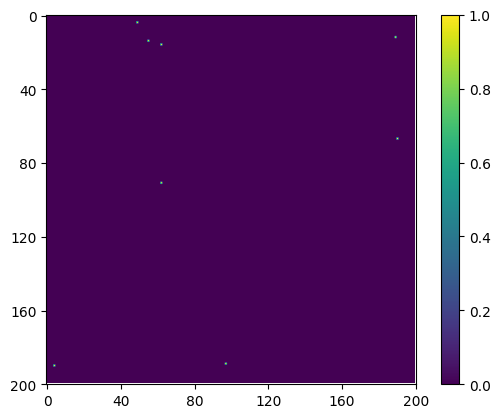

In [24]:
plt.imshow(example_matrix)
plt.yticks(np.arange(0,201,40))
plt.xticks(np.arange(0,201,40))
plt.colorbar()

In [ ]:
np.arange(200,4)

In [18]:
np.linspace(0,200,5)

array([  0.,  50., 100., 150., 200.])

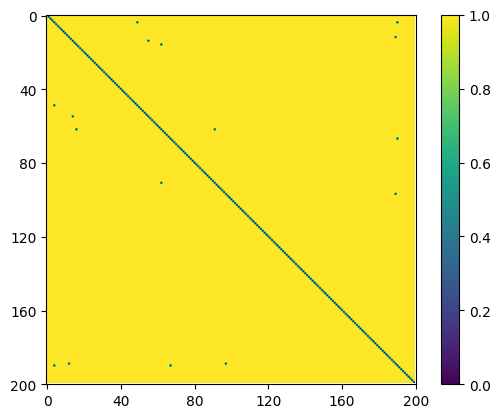

/state/partition1/job-54426488/ipykernel_133065/1727469668.py:32: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance, 'single')


Cluster 5: size: 188, members: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Cluster 1: size: 4, members: [4, 49, 67, 190]
Cluster 4: size: 3, members: [12, 97, 189]
Cluster 3: size: 2, members: [14, 55]


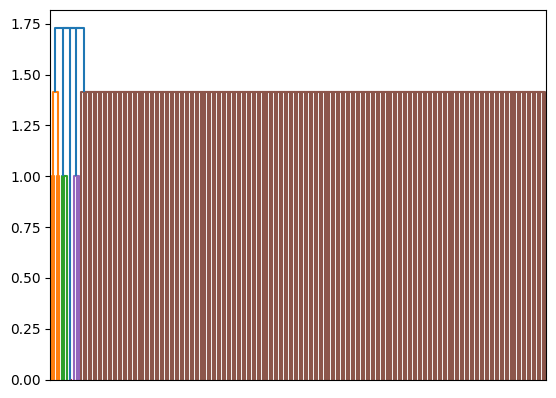

In [38]:
Z_example=min_link_clustering(example_matrix, 1.5)

In [ ]:
Z = min_link_clustering(final_matrix, 1.5)